<a href="https://colab.research.google.com/github/ahhdong/Text-Classification/blob/master/meme_task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label classification

In [ ]:
# import necessary libraries for text classification
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.pipeline import Pipeline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D ,Bidirectional, Dropout
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout
import re
import time
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
from bs4 import BeautifulSoup

seed = 1000

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving labels.csv to labels.csv


In [ ]:
import io
df_meme = pd.read_csv(io.BytesIO(uploaded['labels.csv']))
df_meme.head()

,Unnamed: 0,image_name,text_ocr,text_corrected,humour,sarcasm,offensive,motivational,overall_sentiment
0,0,image_1.jpg,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,LOOK THERE MY FRIEND LIGHTYEAR NOW ALL SOHALIK...,hilarious,general,not_offensive,not_motivational,very_positive
1,1,image_2.jpeg,The best of #10 YearChallenge! Completed in le...,The best of #10 YearChallenge! Completed in le...,not_funny,general,not_offensive,motivational,very_positive
2,2,image_3.JPG,Sam Thorne @Strippin ( Follow Follow Saw every...,Sam Thorne @Strippin ( Follow Follow Saw every...,very_funny,not_sarcastic,not_offensive,not_motivational,positive
3,3,image_4.png,10 Year Challenge - Sweet Dee Edition,10 Year Challenge - Sweet Dee Edition,very_funny,twisted_meaning,very_offensive,motivational,positive
4,4,image_5.png,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,10 YEAR CHALLENGE WITH NO FILTER 47 Hilarious ...,hilarious,very_twisted,very_offensive,not_motivational,neutral


## Reframe the data

In [ ]:
data = df_meme[['text_corrected','humour', 'sarcasm', 'offensive', 'motivational']].copy()
data['text_corrected'] = data['text_corrected'].astype('str')
data.dropna(subset=['text_corrected','humour', 'sarcasm', 'offensive', 'motivational'],inplace=True)
data.reset_index(drop=True, inplace=True)
data.shape

(6992, 5)

## Detect Language

In [ ]:
!pip install langdetect 
from langdetect import detect
data['langue'] = data['text_corrected'].apply(detect)

In [ ]:
# keep the text written in English
data = data[data.langue == 'en']
data.reset_index(drop=True, inplace=True)
data.shape

(5759, 6)

## Data preprocessing

In [ ]:
import re
import nltk
# credit from https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568
nltk.download('stopwords')
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
#credit from:https://datasciencetoday.net/index.php/en-us/tutorials-top/163-sentiment-analysis-using-python-part-i-machine-learning-model-comparison
negations_ = {"isn't":"is not", "can't":"can not","couldn't":"could not", "hasn't":"has not",
                "hadn't":"had not","won't":"will not",
                "wouldn't":"would not","aren't":"are not",
                "haven't":"have not", "doesn't":"does not","didn't":"did not",
                 "don't":"do not","shouldn't":"should not","wasn't":"was not", "weren't":"were not",
                "mightn't":"might not",
                "mustn't":"must not"}
negation_pattern = re.compile(r'\b(' + '|'.join(negations_.keys()) + r')\b')

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text # HTML decoding
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    neg_handled = negation_pattern.sub(lambda x: negations_[x.group()], text)
    text = re.sub('quickmemecom|imgflipcom|memegeneratornet|memecentercom|meme', ' ', text)#some website's titles
    return text

data['text_corrected'] = data['text_corrected'].apply(clean_text)
## set X,y
# X = data['text_corrected']
# y = data["overall_sentiment"]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#encode categorical value
data.loc[:,('humour')] = data.humour.map({"funny" :1, "very_funny" : 1, "hilarious" : 1, "not_funny" : 0})
data.loc[:,('sarcasm')] = data.sarcasm.map({"general" :1, "twisted_meaning" : 1, "very_twisted" : 1, "not_sarcastic" : 0})
data.loc[:,('offensive')] = data.offensive.map({"slight" :1, "very_offensive" : 1, "hateful_offensive" : 1, "not_offensive" : 0})
data.loc[:,('motivational')] = data.motivational.map({"motivational" :1, "not_motivational" : 0})
data.head()

,text_corrected,humour,sarcasm,offensive,motivational,langue
0,look friend lightyear sohalikut trend play 10 ...,1,1,0,0,en
1,best #10 yearchallenge completed less 4 years ...,0,1,0,1,en
2,sam thorne strippin follow follow saw everyone...,1,0,0,0,en
3,10 year challenge sweet dee edition,1,1,1,1,en
4,10 year challenge filter 47 hilarious 10 year ...,1,1,1,0,en


In [ ]:
data.drop(data[data['humour']==0].index & data[data['sarcasm']==0].index 
          & data[data['offensive']==0].index & data[data['motivational']==0].index ,inplace= True)
# data = data[data ==0 & data.sarcasm ==0 & data.offensive ==0 & data.motivational ==0]
data.shape

(5425, 6)

# One hot code scheme

In [ ]:
label_df = data[['humour', 'sarcasm', 'offensive', 'motivational']].copy()
label_df

,humour,sarcasm,offensive,motivational
0,1,1,0,0
1,0,1,0,1
2,1,0,0,0
3,1,1,1,1
4,1,1,1,0
...,...,...,...,...
5754,1,1,1,1
5755,1,1,0,0
5756,1,1,1,0
5757,0,1,0,1


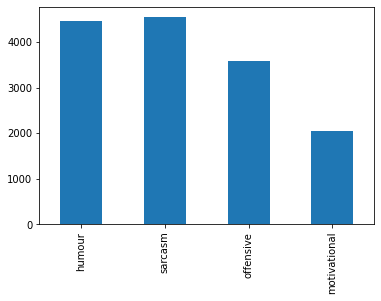

In [ ]:
label_df.sum(axis=0).plot.bar()

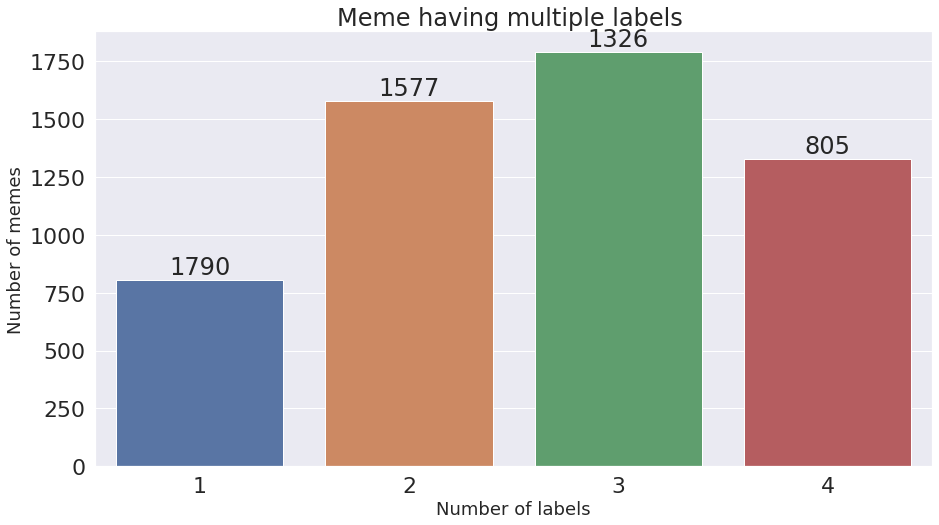

In [ ]:
# credit from:https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff
rowSums = label_df.iloc[:,:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[:]
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Meme having multiple labels ")
plt.ylabel('Number of memes', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

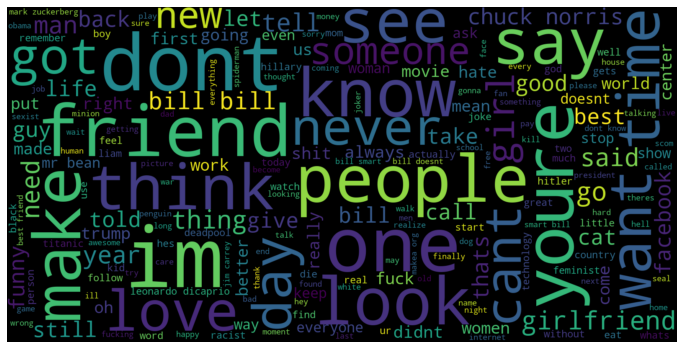

In [ ]:
#word cloud for different labels
# humour label
from wordcloud import WordCloud
h_text = data[data.humour == 1]
h_string = []
for t in h_text.text_corrected:
    h_string.append(t)
h_string = pd.Series(h_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, random_state=seed, max_font_size=200).generate(h_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

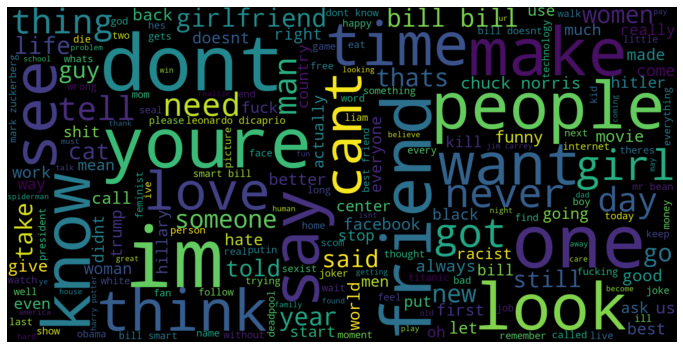

In [ ]:
# sarcasm label
s_text = data[data.sarcasm == 1]
s_string = []
for t in s_text.text_corrected:
    s_string.append(t)
s_string = pd.Series(s_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, random_state=seed, max_font_size=200).generate(s_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

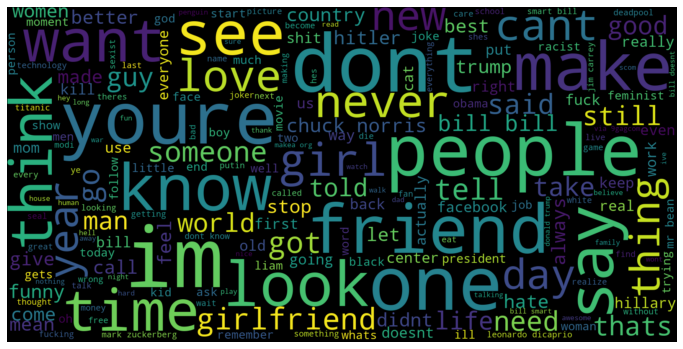

In [ ]:
# offensive label
o_text = data[data.offensive == 1]
o_string = []
for t in o_text.text_corrected:
    o_string.append(t)
o_string = pd.Series(o_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, random_state=seed, max_font_size=200).generate(o_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

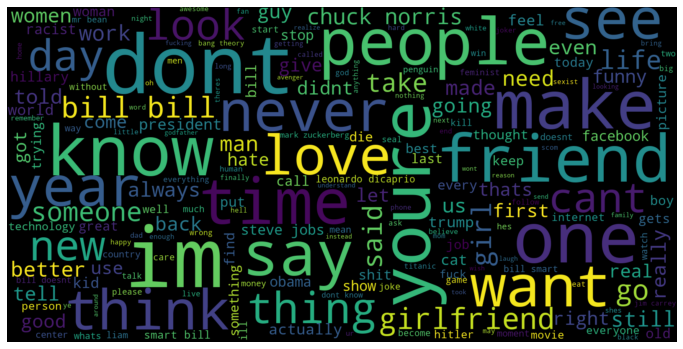

In [ ]:
# motivational label
m_text = data[data.motivational == 1]
m_string = []
for t in m_text.text_corrected:
    m_string.append(t)
m_string = pd.Series(m_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800, random_state=seed, max_font_size=200).generate(m_string)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
X = data['text_corrected']
y = label_df.values
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.1, random_state = seed)

In [ ]:
print(X_train.shape)
print(X_test.shape)

(4882,)
(543,)


# Using ml-KNN

In [ ]:
!pip install scikit-multilearn
from skmultilearn.adapt import MLkNN
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
BOW_MLknn = Pipeline([('bag_of_word',CountVectorizer()),('ml-knn',MLkNN(k=5))])
BOW_MLknn.fit(X_train, Y_train)
tfidf_MLknn = Pipeline([('bag_of_word',CountVectorizer(ngram_range=(1,2))),('tfidf', TfidfTransformer()),('ml-knn',MLkNN(k=5))])
tfidf_MLknn.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('bag_of_word',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('ml-knn', MLkNN(ignore_first_neighbours=0, k=5, s=1.0))],
         verbose=False)

In [ ]:
from sklearn.metrics import classification_report
pre = BOW_MLknn.predict(X_test)
pre2 = tfidf_MLknn.predict(X_test)
print('BOW')
print(classification_report(Y_test, pre))
print('tfidf')
print(classification_report(Y_test, pre2))

BOW
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       449
           1       0.81      0.90      0.85       441
           2       0.67      0.65      0.66       362
           3       0.40      0.27      0.33       211

   micro avg       0.74      0.77      0.76      1463
   macro avg       0.68      0.70      0.68      1463
weighted avg       0.72      0.77      0.74      1463
 samples avg       0.76      0.78      0.72      1463

tfidf
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       449
           1       0.81      0.93      0.86       441
           2       0.66      0.69      0.68       362
           3       0.36      0.27      0.31       211

   micro avg       0.73      0.76      0.75      1463
   macro avg       0.66      0.70      0.68      1463
weighted avg       0.71      0.76      0.74      1463
 samples avg       0.74      0.78      0.71      1463



In [ ]:
from sklearn.metrics import multilabel_confusion_matrix
print(multilabel_confusion_matrix(Y_test, pre))


[[[  0 115]
  [  4 432]]

 [[ 11  99]
  [ 21 420]]

 [[ 70 141]
  [110 230]]

 [[293  47]
  [177  34]]]


## Set up RNN model

In [ ]:
max_words = len(set(" ".join(X_train).split()))
max_len = 200
max_words, max_len

(11236, 200)

In [ ]:
from keras.preprocessing import sequence
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq = sequence.pad_sequences(X_train_seq, maxlen=max_len)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq = sequence.pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
#credit from:https://medium.com/towards-artificial-intelligence/keras-for-multi-label-text-classification-86d194311d0e
model = Sequential()
# Configuring the parameters
model.add(Embedding(max_words, output_dim=50, input_length=max_len))
model.add(LSTM(128, return_sequences=True))  
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(4, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 50)           561800    
_________________________________________________________________
lstm (LSTM)                  (None, 200, 128)          91648     
_________________________________________________________________
dropout (Dropout)            (None, 200, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 260       
Total params: 703,116
Trainable params: 703,116
Non-trainable params: 0
__________________________________________________

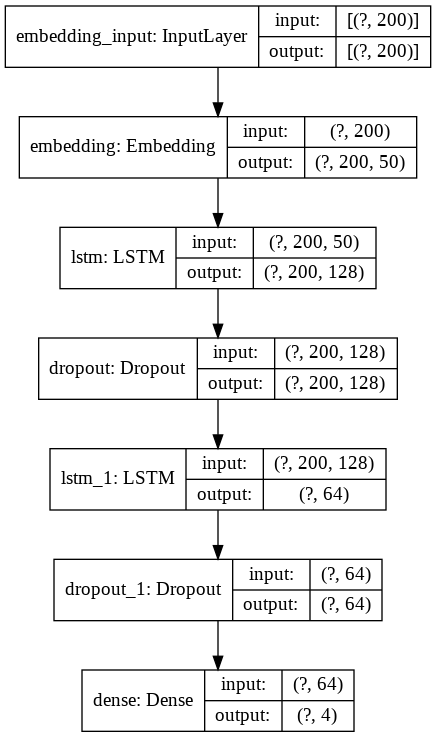

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
# LSTM without dropout
model2 = Sequential()
# Configuring the parameters
model2.add(Embedding(max_words, output_dim=50, input_length=max_len))
model2.add(LSTM(128, return_sequences=True))  
# Adding a dropout layer
# model.add(Dropout(0.5))
model2.add(LSTM(128))
# model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model2.add(Dense(4, activation='sigmoid'))
model2.summary()

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_seq, Y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.1,
                    )

Epoch 1/5
140/140 [==============================] - 4s 28ms/step - loss: 0.5824 - accuracy: 0.3692 - val_loss: 0.5645 - val_accuracy: 0.4182
Epoch 2/5
140/140 [==============================] - 3s 23ms/step - loss: 0.5658 - accuracy: 0.3607 - val_loss: 0.5680 - val_accuracy: 0.1293
Epoch 3/5
140/140 [==============================] - 3s 23ms/step - loss: 0.5311 - accuracy: 0.4386 - val_loss: 0.5819 - val_accuracy: 0.5051
Epoch 4/5
140/140 [==============================] - 3s 23ms/step - loss: 0.4548 - accuracy: 0.5318 - val_loss: 0.6506 - val_accuracy: 0.5798
Epoch 5/5
140/140 [==============================] - 3s 23ms/step - loss: 0.3338 - accuracy: 0.5789 - val_loss: 0.7815 - val_accuracy: 0.5778


In [ ]:
y_pre = model.predict(X_test_seq)

In [ ]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_seq, Y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.1,
                    )

In [ ]:
y_pre = model.predict(X_test_seq)

In [ ]:
# find the optimal threshold
from sklearn.metrics import precision_score, recall_score, f1_score
predictions=y_pre
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(Y_test, pred, average='macro')
    recall = recall_score(Y_test, pred, average='macro')
    f1 = f1_score(Y_test, pred, average='macro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers
Precision: 0.6501, Recall: 0.9579, F1-measure: 0.7663
Micro-average quality numbers
Precision: 0.6517, Recall: 0.9056, F1-measure: 0.7542
Micro-average quality numbers
Precision: 0.6544, Recall: 0.8537, F1-measure: 0.7399
Micro-average quality numbers
Precision: 0.6561, Recall: 0.7800, F1-measure: 0.7124
Micro-average quality numbers
Precision: 0.6596, Recall: 0.7103, F1-measure: 0.6814
Micro-average quality numbers
Precision: 0.6648, Recall: 0.6398, F1-measure: 0.6424
Micro-average quality numbers
Precision: 0.6559, Recall: 0.5660, F1-measure: 0.5892
Micro-average quality numbers
Precision: 0.6691, Recall: 0.4937, F1-measure: 0.5340
Micro-average quality numbers
Precision: 0.6550, Recall: 0.3652, F1-measure: 0.4243


In [ ]:
pred = y_pre
pred[pred>=0.1]=1
pred[pred<0.1]=0

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
labels=['humour',	'sarcasm', 'offensive', 'motivational']
print(classification_report(Y_test, pred, target_names=labels))

              precision    recall  f1-score   support

      humour       0.79      0.99      0.88       436
     sarcasm       0.80      1.00      0.89       441
   offensive       0.62      1.00      0.76       340
motivational       0.39      0.85      0.54       211

   micro avg       0.66      0.97      0.79      1428
   macro avg       0.65      0.96      0.77      1428
weighted avg       0.69      0.97      0.80      1428
 samples avg       0.66      0.98      0.76      1428



In [ ]:
# try Bidirectional layer
modelBi = Sequential()
# Configuring the parameters
modelBi.add(Embedding(max_words, output_dim=50, input_length=max_len))
modelBi.add(Bidirectional(LSTM(128, return_sequences=True)))
# Adding a dropout layer
modelBi.add(Dropout(0.5))
modelBi.add(LSTM(64))
modelBi.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
modelBi.add(Dense(4, activation='sigmoid'))
modelBi.summary()

In [ ]:
modelBi.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = modelBi.fit(X_train_seq, Y_train,
                    epochs=5,
                    batch_size=32,
                    validation_split=0.1,
                    )

In [ ]:
y_pre1 = modelBi.predict(X_test_seq)

In [ ]:
# find the optimal threshold
from sklearn.metrics import precision_score, recall_score, f1_score
predictions=y_pre1
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(Y_test, pred, average='micro')
    recall = recall_score(Y_test, pred, average='micro')
    f1 = f1_score(Y_test, pred, average='macro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()